# Personal Assignment: Unsaturated Flow Model with Preferential Flow
**Eunice Koid (5278023)**\
**CIE4365 Modeling Coupled Processes | Final Q4 2021**

This code expands upon the unsaturated water flow problem with the Richards Equation to include preferential flow. Prefential flow is added by using the dual porosity approach where porosity of the soil is divided into fractions that control two flows: 1. fast flow, and 2. slow flow. The internal porosity is the slow flow domain. Cracks surrounding the porous aggregates are the fast flow porosity. The overall behavior of the flow is controlled both slow and fast domains. 

Using the Richards Equation in pressure head form as the fundamental equation to model unsaturated water flow, the dual porosity concept is incorporated to include preferential flow.

In [1]:
## Import packages that are needed
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import pandas as pd
import seaborn as sns
import scipy.integrate as spi
import scipy.sparse as sp

In [2]:
## Assign values to variables related to the soil column under analysis
soil_col_length = 1 # m
phreatic_w = 25*10**-2 # 25 cm is the phreatic water level 

## Basic Equation Functions

This section contains the specified functions that return the values of basic equations needed to model preferential flow. Note that H refers to h_w, the water pressure head.

### Effective Saturation

In [3]:
## Effective Saturation Function
## This function calculates the effective saturation as a function 
##   of water pressure head (hw)
## The Van Genuchten equation is used in this model

def S_eff(H_fast, H_slow, soilPar):
    h_cf = -H_fast
    h_cs = -H_slow 
    # the capillary head is equal to the negative 
    #  of pressure head because the air pressure head is 
    #  assumed to be zero everywhere (Pinder and Celia, 2006)
    S_eff_f = (1 + ((h_cf * (h_cf > 0)) * soilPar.VGalphaf) ** soilPar.VGnf) ** (-soilPar.VGmf)
    S_eff_s = (1 + ((h_cs * (h_cs > 0)) * soilPar.VGalphas) ** soilPar.VGns) ** (-soilPar.VGms)             # This equation is from Pinder and Celia (2006)

    return S_eff_f, S_eff_s

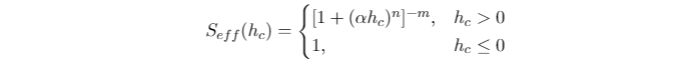

### Saturated Water Content (theta_sat)

In [4]:
## In the dual porosity model, effective saturation (theta_sat) = 
##  theta_sat_fast + theta_sat_slow

def theta_sat_fast(soilPar):
    return soilPar.B * soilPar.theta_sat

def theta_sat_slow(soilPar):
    return (1-soilPar.B) * soilPar.theta_sat

### Water Content (theta_w)

In [5]:
## Water Content as a function of water pressure head
## This function also uses Van Genuchten equation to find the volumetric
##   water content (theta_w)
def Water_Content(H_fast, H_slow, soilPar):
    seff = S_eff(H_fast, H_slow, soilPar)
    theta_f = seff[0] * (theta_sat_fast(soilPar) - soilPar.theta_resf) + soilPar.theta_resf
    theta_s = seff[1] * (theta_sat_slow(soilPar) - soilPar.theta_ress) + soilPar.theta_ress
    return theta_f, theta_s

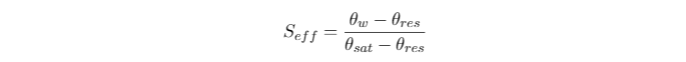

### Exchange of water between fast and slow porosities (Q_exchange)

In [6]:
## Fast and slow flow porosities are coupled by Q_exchange 
##  Q_exchange = -k_ex (H_fast-H_slow)

def Q_exchange(H_fast, H_slow, soilPar):

    #nr,nc = H_fast.shape
    #Qex = np.zeros([nIN, nc], dtype=H_fast.dtype)
    Qex = -soilPar.Kex * (H_fast - H_slow)
    return Qex

### Differential Water Capacity

In [7]:
## Differential Water Capacity - C(hw) = dtheta_w/dhw
## This function finds the differential water capcity for the 
##   Richards Equation using complex derivative

def C_hw_derivative(H_fast, H_slow, soilPar):
    
    dh = np.sqrt(np.finfo(float).eps)
    if np.iscomplexobj(H_fast):
        hcmplxF = H_fast.real + 1j*dh
    if np.iscomplexobj(H_slow):
        hcmplxS = H_slow.real + 1j*dh
    else:
        hcmplxF = H_fast.real + 1j*dh
        hcmplxS = H_slow.real + 1j*dh
        
    th = Water_Content(hcmplxF, hcmplxS, soilPar)
    C_F = th[0].imag / dh
    C_S = th[1].imag / dh
    return C_F, C_S

### Unsaturated Hydraulic Conductivity

In [8]:
## Unsaturated Hydraulic Conductivity as a function of pressure head
## This function considers the relative permeability and the 
##   permeability to find the unsaturated hydraulic conductivity which 
##   is K_sat*k_rw in the Richards Equation 

def K_vector(H_fast, H_slow, soilPar, modelDim):
    nr,nc = H_fast.shape
    nIN = modelDim.nIN
    zIN = modelDim.zIN
    
    k_rwf = (S_eff(H_fast, H_slow, soilPar)[0])**3 # relative permeability fast flow
    K_satf = soilPar.Ksatf
    Knf = k_rwf * K_satf
    
    K_sats = soilPar.Ksats
    k_rws = (S_eff(H_fast, H_slow, soilPar)[1])**3 # relative permeability slow flow
    Kns = k_rws * K_sats
    
    # Permeability vector for the fast and slow flow regime
    KINfast = np.zeros([nIN, nc], dtype=H_fast.dtype)
    KINslow = np.zeros([nIN, nc], dtype=H_slow.dtype)
    
    # Permeability at the bottom boundary
    KINfast[0] = Knf[0]
    KINslow[0] = Kns[0]
    
    # Permeability at the internodes
    ii = np.arange(1, nIN - 1)
    KINfast[ii] = (Knf[ii] +Knf[ii - 1]) / 2
    KINslow[ii] = (Kns[ii] +Kns[ii - 1]) / 2
    
    # Permeabilit At the top
    KINfast[nIN - 1] = Knf[nIN - 2]
    KINslow[nIN - 1] = Kns[nIN - 2]
    
    return KINfast, KINslow

### Top Boundary Condition 

In [9]:
## Function that returns the top boundary flux condition
def BndqTop(t, boundaryPar):
    bndqTop = -0.001 * (t > 25) * (t < 225) 
    # between 25 to 225 days, q = -0.001 m/day 
    # then q=0 m/day for the next 200 days
    
    #bndqTop = -0.002 # use this to increase the flow 
    
    return bndqTop

## Mass Matrices

**Richards Equation in Pressure Head Form**
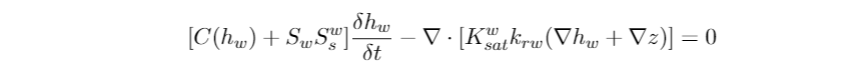

In [10]:
## Mass Matrix Function 
##  M(y,t) from [ M(y,t)*y'= f(t,y) ] 
##  In this model, the mass matrix is [C(hw) + S_w + S_sw] in the 
##  Richards Equation in pressure head form 

def C_eff_Mat(H_fast, H_slow, soilPar, modelDim):
    theta = Water_Content(H_fast, H_slow, soilPar)
    S_wF = theta[0] / theta_sat_fast(soilPar)
    S_wS = theta[1] / theta_sat_slow(soilPar)
    C_hwF = C_hw_derivative(H_fast, H_slow, soilPar)[0]
    C_hwS = C_hw_derivative(H_fast, H_slow, soilPar)[1]
    
    beta = 1E-10
    rho_w = 1000 # kg/m3
    g = 9.81 
    cv = 1E-8
    
    S_swF = rho_w * g * (cv + theta[0] * beta) # Storativity for fast flow 
    S_swS = rho_w * g * (cv + theta[1] * beta) # Storativity for slow flow 
    RF = C_hwF + S_wF * S_swF 
    RS = C_hwS + S_wS * S_swS 
    
    # Ponding water condition when hw(-1) >= 0
    # if head at top is larger or equal to 0, ponding water table
    # which is implementd by changing the differential water
    # capacity in order to make the equation:
    # dhw/dt = qbnd - q(n-1/2)
    
    #RS[modelDim.nN-1] = 1/modelDim.dzIN[modelDim.nIN-2] * (H_slow[modelDim.nN-1]>0) \
    #    + RS[modelDim.nN-1] * (H_slow[modelDim.nN-1]<=0)
    
    return RF, RS

## Water Flux & Divergence of Water Flux

In [11]:
## Function that calculates and returns water flux at each internode
##  f(t,y)
def WaterFlux(t, H_fast, H_slow, soilPar, modelDim, boundaryPar):
    nIN = modelDim.nIN
    dzN = modelDim.dzN
    
    # inter nodes permeability
    KINf = K_vector(H_fast, H_slow, soilPar, modelDim)[0]
    KINs = K_vector(H_fast, H_slow, soilPar, modelDim)[1]

    # flux vector
    nr,nc = H_fast.shape
    qfast = np.zeros([nIN, nc], dtype=H_fast.dtype)
    qslow = np.zeros([nIN, nc], dtype=H_slow.dtype)
   
    bndQtop = BndqTop(t, boundaryPar)
    # Assign top boundary for flux
    qfast[nIN - 1] = bndQtop #Neuman
    qslow[nIN - 1] = 0 # Neuman
    
    # Flux at internodes
    ii = np.arange(1, nIN-1)
    qfast[ii] = -KINf[ii]*((H_fast[ii] - H_fast[ii-1]) / dzN[ii-1] + 1)
    qslow[ii] = -KINs[ii]*((H_slow[ii] - H_slow[ii-1]) / dzN[ii-1] + 1)
    
    # Bottom layer
    if boundaryPar.BotCond == 'Gravity': # Only gravity flow
        qfast[0] = -KINf[0] #+ 0.001   
        qslow[0] = -KINs[0] #+ 0.001
    else: # Robbin condition
        qfast[0] = -boundaryPar.res_rob * (H_fast[0] - boundaryPar.H_rob_bot) #+ 0.001  
        qslow[0] = -boundaryPar.res_rob * (H_slow[0] - boundaryPar.H_rob_bot) #+ 0.001 
        
    return qfast, qslow

In [12]:
## Function that calculates and returns the divergent of the waterflux
##  y' = f(t,y / M(y,t)

def DivWaterFlux(t, H_fast, H_slow, soilPar, modelDim, boundaryPar):
    nr,nc = H_fast.shape
    nN = modelDim.nN
    dzIN = modelDim.dzIN
    
    Qex = Q_exchange(H_fast, H_slow, soilPar) #?? unsure it goes here
    
    C_F = C_eff_Mat(H_fast, H_slow, soilPar, modelDim)[0]
    C_S = C_eff_Mat(H_fast, H_slow, soilPar, modelDim)[1] 

    # Calculate fluxes across all internodes
    qf = WaterFlux(t, H_fast, H_slow, soilPar, modelDim, boundaryPar)[0] #Flow for the fast regime
    qs = WaterFlux(t, H_fast, H_slow, soilPar, modelDim, boundaryPar)[1] #Flow for the slow regime
    
    divqf = np.zeros([nN, nc]).astype(H_fast.dtype)
    divqs = np.zeros([nN, nc]).astype(H_slow.dtype) 
    
    # Calculate divergence of flux for all nodes
    ii = np.arange(0, nN)  
    divqf[ii] = -(qf[ii+1] - qf[ii] - Qex[ii]) / (dzIN[ii]* C_F[ii]) 
    divqs[ii] = -(qs[ii+1] - qs[ii] + Qex[ii]) / (dzIN[ii]* C_S[ii])
    
    divq = np.vstack((divqf, divqs))
    return divq


## Complex Jacobian Matrix Function

**Unsaturated Flow**

In [13]:
## Complex Jacobian Matrix Function 
def Jac_Richard_Cmplx(t, y, soilPar, modelDim, boundaryPar):
    nr, nc = y.shape
    dh = np.sqrt(np.finfo(float).eps)
    jac = np.zeros((nr,nr))
    
    for ii in np.arange(nr):
        ycmplx = y.copy().astype(complex)
        ycmplx[ii] = ycmplx[ii] + 1j*dh
        dfdy = DivWaterFlux(t,ycmplx,soilPar,modelDim,boundaryPar).imag/dh
        jac[:,ii] = dfdy.squeeze()
    return jac

**Dual Porosity Model**

In [14]:
## Complex Jacobian Matrix Function 
def Jac_Richard_Cmplx_Fast(t, y, soilPar, modelDim, boundaryPar):
    nr, nc = y.shape
    dh = np.sqrt(np.finfo(float).eps)
    jac = np.zeros((nr,nr))
    
    for ii in np.arange(nr):
        ycmplx = y.copy().astype(complex)
        ycmplx[ii] = ycmplx[ii] + 1j*dh
        dfdy = DivWaterFluxFast(t,ycmplx,soilPar,modelDim,boundaryPar).imag/dh
        jac[:,ii] = dfdy.squeeze()
    return jac

def Jac_Richard_Cmplx_Slow(t, y, soilPar, modelDim, boundaryPar):
    nr, nc = y.shape
    dh = np.sqrt(np.finfo(float).eps)
    jac = np.zeros((nr,nr))
    
    for ii in np.arange(nr):
        ycmplx = y.copy().astype(complex)
        ycmplx[ii] = ycmplx[ii] + 1j*dh
        dfdy = DivWaterFluxSlow(t,ycmplx,soilPar,modelDim,boundaryPar).imag/dh
        jac[:,ii] = dfdy.squeeze()
    return jac

## Domain Discretization

In [15]:
# **Domain Discretization**
# Domain
nIN = 101

# Soil profile 
zIN = np.linspace(-soil_col_length, 0, num=nIN).reshape(nIN, 1)
zN = np.zeros((nIN-1)).reshape(nIN-1, 1) 
zN[0, 0] = zIN[0, 0]
zN[1:nIN - 2, 0] = (zIN[1:nIN - 2, 0] + zIN[2:nIN - 1, 0]) / 2
zN[nIN - 2, 0] = zIN[nIN - 1]
nN = np.shape(zN)[0]

ii = np.arange(0, nN - 1)
dzN = (zN[ii + 1, 0] - zN[ii, 0]).reshape(nN - 1, 1)
dzIN = (zIN[1:, 0] - zIN[0:-1, 0]).reshape(nIN - 1, 1)

# collect model dimensions in a namedtuple: modDim
modDim = namedtuple('ModDim', ['zN', 'zIN', 'dzN', 'dzIN', 'nN', 'nIN'])
modelDim = modDim(zN=zN,
              zIN=zIN,
              dzN=dzN,
              dzIN=dzIN,
              nN=nN,
              nIN=nIN)
#----------------------------------------------------------------------------------------------------    

# Water Properties
rho_w = 1000 # kg/m3, density of water
#mu_w = 10**-3 # Pa*s, viscosity of water



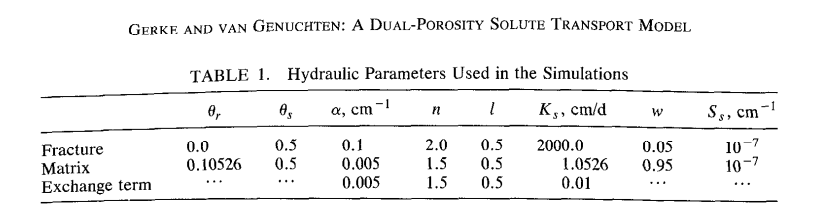

In [16]:

## Collect soil parameters in a namedtupple: soilPar     
## Here the parameters for soiltype is sand See Mayer ch2
soilPar = namedtuple('soilPar', ['Ksatf', 'VGalphaf', 'VGnf', 
                                 'VGmf', 'theta_resf', #'theta_satf', 
                                 'theta_sat',
                                 'Ksats', 'VGalphas', 'VGns', 
                                 'VGms', 'theta_ress', #'theta_sats',
                                 'B', 'Kex'])

                  ## Soil parameters fast regime, Coarse soil 
soilPar = soilPar(Ksatf = np.ones(np.shape(zN))* 20, # m/day Saturated hydraulic conductivity
                  VGalphaf = np.ones(np.shape(zN)) *  10, # 1/m 
                  VGnf = np.ones(np.shape(zN)) * 2.0, # 2.68, # [-] 
                  VGmf = np.ones(np.shape(zN)) * (1 - 1/2), 
                  theta_resf = np.ones(np.shape(zN)) * 0.065, # residual water content
                  theta_sat = np.ones(np.shape(zN)) * 0.5,
                 
                  ## Soilparameters for slow regime, Fine soil 
                  Ksats = np.ones(np.shape(zN))* 0.010526,  # m/day Saturated hydraulic conductivity
                  VGalphas = np.ones(np.shape(zN)) * 0.5, # 1/m 
                  VGns = np.ones(np.shape(zN)) * 1.5,  # [-] 
                  VGms = np.ones(np.shape(zN)) * (1 - 1/1.5), 
                  theta_ress = np.ones(np.shape(zN)) * 0.10526, # residual water content
                  
                  B = 0.2, # the fraction of the porosity associated with the fast flow (generally between 2 and 30 %)
                  Kex = 0.010526*10**-3
                 )

#----------------------------------------------------------------------------------------------------    

# Boundary Parameters Definition 
boundaryPar = namedtuple('boundPar', ['BotCond',
                                   'res_rob','H_rob_bot'])
boundaryPar = boundaryPar(BotCond='Robbin', # 'Robbin', # 
                         res_rob =  432, #m/day , 0.005,# m/s
                         H_rob_bot = -1.0)

#----------------------------------------------------------------------------------------------------    

# Initial Conditions fast flow
HIni = np.zeros(np.shape(zN))
zRef = - phreatic_w # at 0.25 depth is the watertable
HIni = zRef - zN  # intitial from bottom hw= 0.75 to top hw= -0.25
H0_f = HIni.copy().squeeze()

# Initial Conditions slow flow
HIni = np.zeros(np.shape(zN))
zRef = - phreatic_w # at 0.25 depth is the watertable
HIni = zRef - zN  # intitial from bottom hw= 0.75 to top hw= -0.25
H0_s = HIni.copy().squeeze()

## Two-state vector by stacking. Inital y0 for the solver.
y0 = np.concatenate((H0_f, H0_s))  #shape (200,)


#----------------------------------------------------------------------------------------------------    

## Time Discretization
tOut =  np.logspace(-14, np.log10(70), num=1000)#np.arange(0,226,1)  # 
nOut = np.shape(tOut)[0]
t_span = [tOut[0], tOut[-1]]

#------------------------------

## Functions to Prepare for ODE Solver

In [17]:
## Function to return differential so that ODE solver can solve 
## Splits the state vector, solves both models and return changes
##   in the statevector as one again.

def intFun(t, sVec):
    
    # solver switches between zeroD and matrix shaped states
    # take this into account to create a rate function that
    # works for every case
        
    if len(sVec.shape) == 1:
        sVec = sVec.reshape(2 * modelDim.nN, 1)

    nN = modelDim.nN
    
    # unpack states
    Hfast = sVec[0:nN]
    Hslow = sVec[nN:2*nN]
    
    dH = DivWaterFlux(t, Hfast, Hslow, soilPar, modelDim, boundaryPar)

    return dH

In [18]:
## Jacobian Matrix Function (Complex Jacobian)
def jacFun(t, y):
    if len (y.shape) == 1:
        y = y.reshape (2 * modelDim.nN, 1)
        nr , nc = y.shape
        dh = np.sqrt(np.finfo(float).eps)
        
        ycmplx = np.repeat(y , nr , axis =1).astype(complex)
        c_ex = np.eye(nr) * 1j * dh
        ycmplx = ycmplx + c_ex
        
        # calculate complex derivative for Waterflow
        dfdy = DivWaterFlux(t, ycmplx[:modelDim.nN], ycmplx[modelDim.nN:], soilPar,modelDim,boundaryPar).imag/dh
        
        #Definition of the complex jacobian
        dfdy = dfdy.squeeze()
        
    return sp.coo_matrix(dfdy)

In [19]:
## Solves Rate equation for only unsaturated flow
HODE = spi.solve_ivp(intFun, t_span, 
                     y0, method='BDF', 
                     t_eval=tOut, 
                     vectorized=True, 
                     rtol=1e-8, 
                     jac=jacFun)

## Plotting

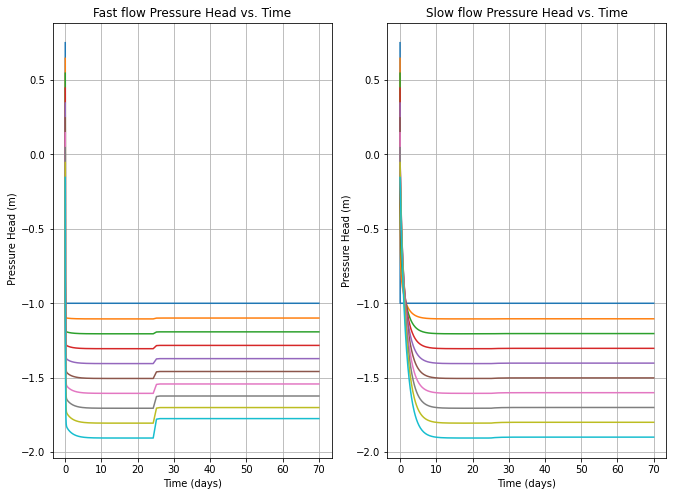

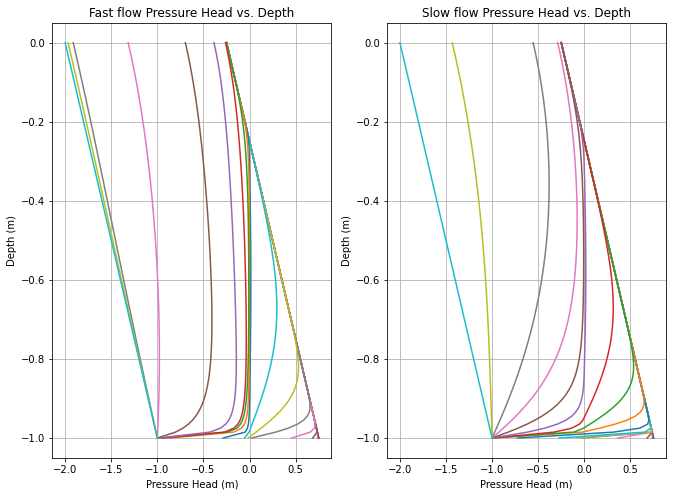

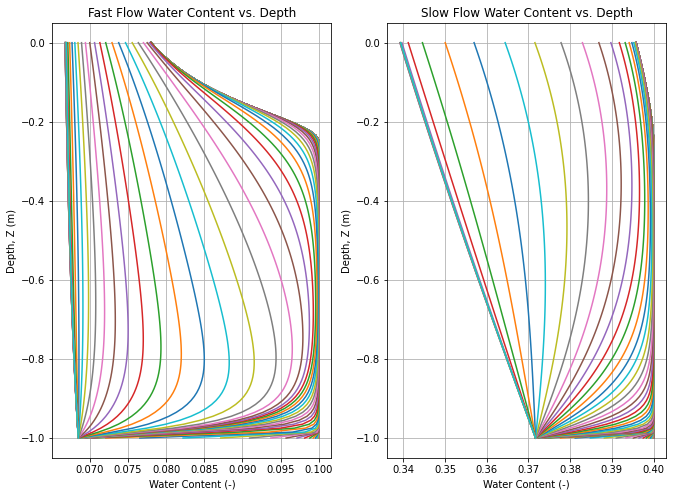

In [20]:
## Retrieve solved parameters
Hfast = HODE.y[:nN]
Hslow = HODE.y[nN:]

#---------------------------------------------------------------------------------------------------- 

## Plot pressure head against time
plt.close('all')
fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
for ii in np.arange(0, nN, 10):
    ax1.plot(HODE.t, Hfast[ii,:], '-',label=ii)
    ax2.plot(HODE.t, Hslow[ii,:], '-',label=ii)

ax1.set_title('Fast flow Pressure Head vs. Time')
ax1.set_ylabel(' Pressure Head (m)')
ax1.set_xlabel('Time (days)')
#ax1.legend()
ax1.grid(b=True) 

ax2.set_title('Slow flow Pressure Head vs. Time')
ax2.set_ylabel('Pressure Head (m)')
ax2.set_xlabel('Time (days)')
#ax2.legend()
ax2.grid(b=True) 

#----------------------------------------------------------------------------------------------------        

## Plot pressure head against depth

fig2, [ax3, ax4] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
for ii in np.arange(0, nOut, 50):
    ax3.plot(Hfast[:,ii], zN, '-',label=ii)
    ax4.plot(Hslow[:,ii], zN, '-',label=ii)

ax3.set_title('Fast flow Pressure Head vs. Depth')
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Pressure Head (m)')
#ax3.legend()
ax3.grid(b=True) 

ax4.set_title('Slow flow Pressure Head vs. Depth')
ax4.set_ylabel('Depth (m)')
ax4.set_xlabel('Pressure Head (m)')
#ax4.legend()
ax4.grid(b=True) 
# #---------------------------------------------------------------------------------------------------- 

# Plotting water content against Depth
theta_f = Water_Content(Hfast, Hslow, soilPar)[0]
theta_s = Water_Content(Hfast, Hslow, soilPar)[1] 

fig3, [ax5, ax6] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
ax5.plot(theta_f[0:100:1, 0:1000:10], zN) #'-',label=ii)
ax6.plot(theta_s[0:100:1, 0:1000:10], zN) #'-',label=ii)

ax5.set_title('Fast Flow Water Content vs. Depth')
ax5.set_xlabel('Water Content (-)')
ax5.set_ylabel('Depth, Z (m)')
# ax5.legend()
ax5.grid(b=True) 

ax6.set_title('Slow Flow Water Content vs. Depth')
ax6.set_xlabel('Water Content (-)')
ax6.set_ylabel('Depth, Z (m)')
# ax6.legend()
ax6.grid(b=True) 

#---------------------------------------------------------------------------------------------------- 


plt.show()

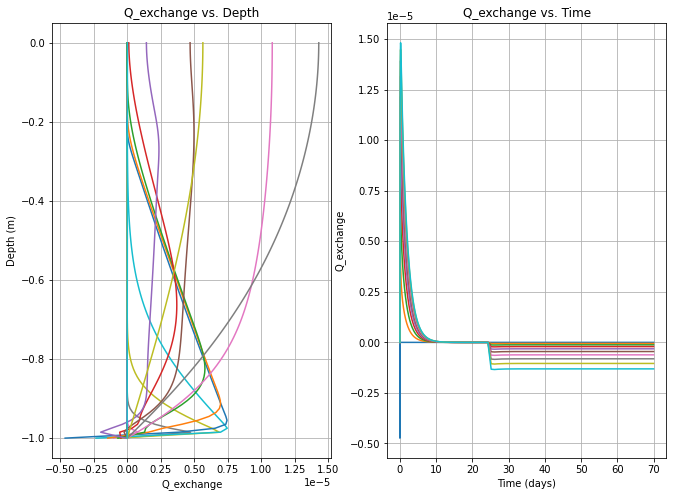

In [21]:
## Plot Qex
Qex = Q_exchange(Hfast, Hslow, soilPar)
fig4, [ax7, ax8] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
for ii in np.arange(0, nOut, 50):
    ax7.plot(Qex[:,ii], zN, '-',label=ii)

    
for ii in np.arange(0, nN, 10):
    ax8.plot(HODE.t, Qex[ii,:], '-',label=ii)
    
ax7.set_title('Q_exchange vs. Depth')
ax7.set_ylabel('Depth (m)')
ax7.set_xlabel('Q_exchange')
#ax7.legend()
ax7.grid(b=True) 

ax8.set_title('Q_exchange vs. Time')
ax8.set_ylabel('Q_exchange')
ax8.set_xlabel('Time (days)')
#ax8.legend()
ax8.grid(b=True) 

plt.show()


**Plotting Water Flow of fast and slow flow domains**

Text(0.5, 1.0, 'Fast and slow flow (blue=fast; red=slow)')

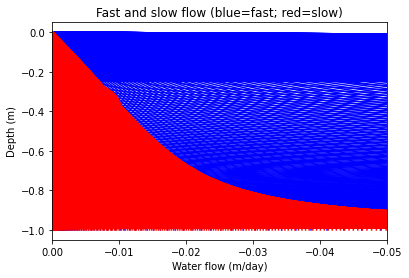

In [22]:
qfast = WaterFlux(HODE.t, Hfast, Hslow, soilPar, modelDim, boundaryPar)[0]
qslow = WaterFlux(HODE.t, Hfast, Hslow, soilPar, modelDim, boundaryPar)[1]

plt.xlim(0,-0.05)
plt.plot(qfast, zIN, color='b', label='Fast flow')
plt.plot(qslow, zIN, color='r', label='Slow flow')
#plt.legend()
plt.ylabel('Depth (m)')
plt.xlabel('Water flow (m/day)')
plt.title("Fast and slow flow (blue=fast; red=slow)")

**Plotting Hydraulic Conductivity vs. Pressure Head**

In [23]:
# With Coupling
hycondfast, hycondslow = K_vector(Hfast, Hslow, soilPar, modelDim)
hycondfast = np.delete(hycondfast, 0, axis=0)
hycondslow = np.delete(hycondslow, 0, axis=0)
# Hfast.shape = (101,1000)

#pd.DataFrame(hycondfast).to_csv('hycondfast.csv')

hycondfast = hycondfast[:, 0:1]
hycondslow = hycondslow[:, 0:1]

#hycondfast = np.delete(hycondfast, slice(999), axis=1)
#hycondslow = np.delete(hycondslow, slice(999), axis=1)
# hycondslow.shape (100, 1)

In [24]:
# Without Coupling 
Hfast2 = np.arange(start=0.75, stop=-0.25, step=-0.01).reshape(100,1)
Hslow2 = np.arange(start=0.75, stop=-0.25, step=-0.01).reshape(100,1)
hycondfast2, hycondslow2 = K_vector(Hfast2, Hslow2, soilPar, modelDim)
hycondfast2 = np.delete(hycondfast2, 0, axis=0)
hycondslow2 = np.delete(hycondslow2, 0, axis=0)

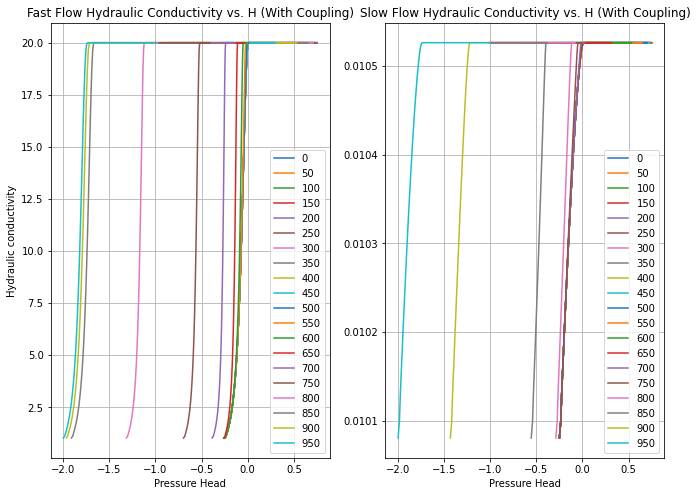

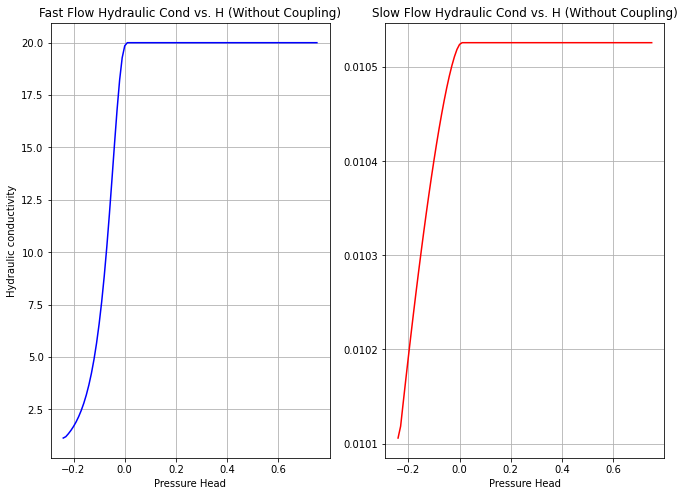

In [25]:
fig5, [ax9, ax10] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
for ii in np.arange(0, nOut, 50):
    ax9.plot(Hfast[:,ii], hycondfast, '-', label=ii)
    ax10.plot(Hslow[:,ii], hycondslow, '-', label=ii)

ax9.legend()
ax9.set_ylabel('Hydraulic conductivity')
ax9.set_xlabel('Pressure Head')
ax9.set_title("Fast Flow Hydraulic Conductivity vs. H (With Coupling)")
ax9.grid(b=True) 

ax10.legend()
ax10.set_xlabel('Pressure Head')
ax10.set_title("Slow Flow Hydraulic Conductivity vs. H (With Coupling)")
ax10.grid(b=True) 

#----------------------without coupling---------------------------
fig5b, [ax9b, ax10b] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
ax9b.plot(Hfast2, hycondfast2, color='b', label='Fast flow')
ax10b.plot(Hslow2, hycondslow2, color='r', label='Slow flow')

#ax9.legend()
ax9b.set_ylabel('Hydraulic conductivity')
ax9b.set_xlabel('Pressure Head')
ax9b.set_title("Fast Flow Hydraulic Cond vs. H (Without Coupling)")
ax9b.grid(b=True) 

#ax10.legend()
ax10b.set_xlabel('Pressure Head')
ax10b.set_title("Slow Flow Hydraulic Cond vs. H (Without Coupling)")
ax10b.grid(b=True) 

**Plotting Water Content vs. Pressure Head at a point in time**

In [26]:
theta_f = Water_Content(Hfast, Hslow, soilPar)[0]
theta_s = Water_Content(Hfast, Hslow, soilPar)[1]
theta_f2 = theta_f[:, 0:1]
theta_s2 = theta_s[:, 0:1]

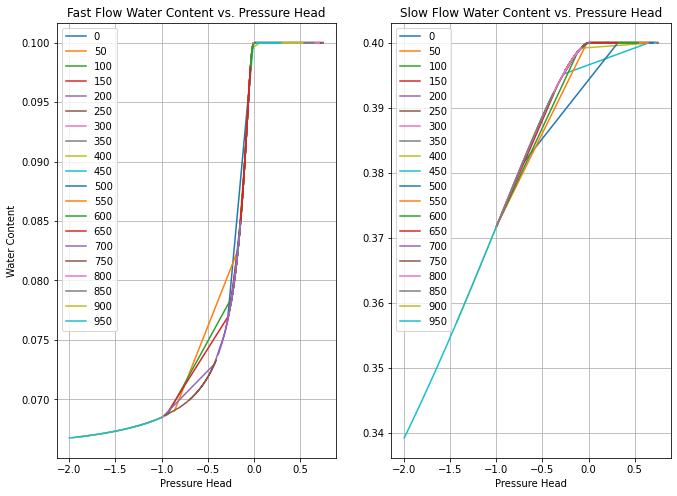

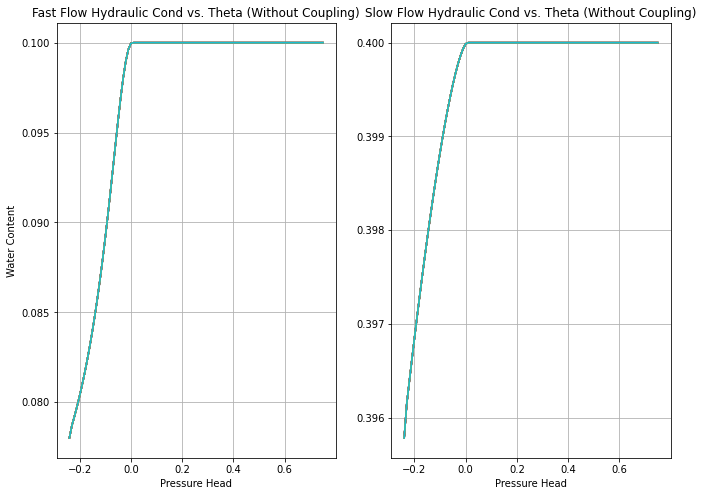

In [27]:
fig6, [ax11, ax12] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 

for ii in np.arange(0, nOut, 50):
    ax11.plot(Hfast[:,ii], theta_f[:,ii], '-', label=ii)
    ax12.plot(Hslow[:,ii], theta_s[:,ii], '-', label=ii)

ax11.legend()
ax11.set_ylabel('Water Content')
ax11.set_xlabel('Pressure Head')
ax11.set_title("Fast Flow Water Content vs. Pressure Head")
ax11.grid(b=True) 

ax12.legend()
ax12.set_xlabel('Pressure Head')
ax12.set_title("Slow Flow Water Content vs. Pressure Head")
ax12.grid(b=True) 

#----------------------without coupling---------------------------
fig6b, [ax11b, ax12b] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 

for ii in np.arange(0, nOut, 50):
    ax11b.plot(Hfast2, theta_f2, '-', label=ii)
    ax12b.plot(Hslow2, theta_s2, '-', label=ii)


#ax11.legend()
ax11b.set_ylabel('Water Content')
ax11b.set_xlabel('Pressure Head')
ax11b.set_title("Fast Flow Hydraulic Cond vs. Theta (Without Coupling)")
ax11b.grid(b=True) 

#ax12.legend()
ax12b.set_xlabel('Pressure Head')
ax12b.set_title("Slow Flow Hydraulic Cond vs. Theta (Without Coupling)")
ax12b.grid(b=True) 

## Mass Balance / Error Calculation

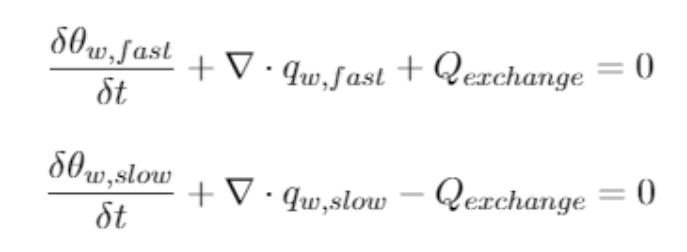

In [28]:
## Water Balance 
Qex = Q_exchange(Hfast, Hslow, soilPar) # (100, 1000) shape

# Calculate fluxes across all internodes
qf = WaterFlux(HODE.t, Hfast, Hslow, soilPar, modelDim, boundaryPar)[0] #Flow for the fast regime
qs = WaterFlux(HODE.t, Hfast, Hslow, soilPar, modelDim, boundaryPar)[1] #Flow for the slow regime

nr, nc = Hfast.shape

divqf = np.zeros([nN, nc]).astype(Hfast.dtype)
divqs = np.zeros([nN, nc]).astype(Hslow.dtype) 

# Calculate divergence of flux for all nodes
for ii in np.arange(0,nN):
    divqf[ii] = -(qf[ii+1] - qf[ii]) / (dzIN[ii]) 
    divqs[ii] = -(qs[ii+1] - qs[ii]) / (dzIN[ii])

# divqf.shape = (100, 1000)

In [29]:
MassBalFast = theta_f/HODE.t + divqf + Qex
MassBalSlow = theta_s/HODE.t + divqs - Qex

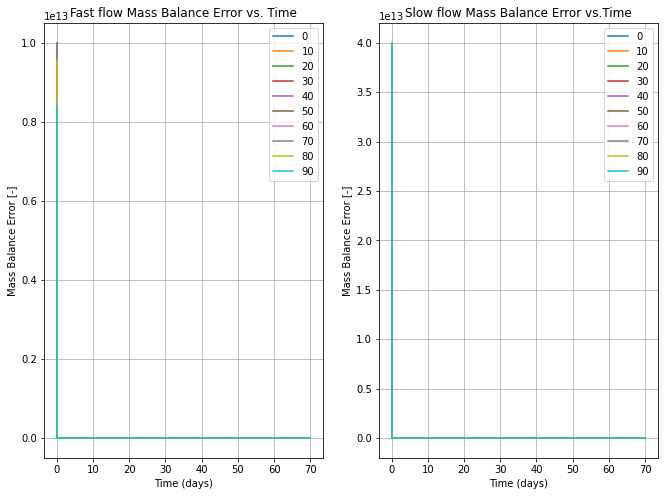

In [30]:
fig7, [ax13, ax14] = plt.subplots(nrows=1, ncols=2, figsize=(11, 8)) 
for ii in np.arange(0, nN, 10):
    ax13.plot(HODE.t, MassBalFast[ii,:], '-',label=ii)
    ax14.plot(HODE.t, MassBalSlow[ii,:], '-',label=ii)

ax13.set_title('Fast flow Mass Balance Error vs. Time')
ax13.set_ylabel('Mass Balance Error [-]')
ax13.set_xlabel('Time (days)')
ax13.legend()
ax13.grid(b=True) 

ax14.set_title('Slow flow Mass Balance Error vs.Time')
ax14.set_ylabel('Mass Balance Error [-]')
ax14.set_xlabel('Time (days)')
ax14.legend()
ax14.grid(b=True) 